**Packages**

In [42]:
import numpy as np
import pandas as pd
import math
import seaborn as sn

import matplotlib
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import concatenate
import tensorflow_addons as tfa

from keras.callbacks import ModelCheckpoint
from keras.models import load_model

import sklearn

import tifffile

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.preprocessing import LabelBinarizer, normalize


import os

import scipy

**Helper Functions**

In [43]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='train_loss')
    plt.plot(history.history['val_loss'], label='val_loss')
   # plt.plot(history.history['accuracy'], label='accuracy')
   # plt.plot(history.history['val_accuracy'], label='val_accuracy')
    plt.ylim([0, 
            max(
                max(history.history['loss']),
                max(history.history['val_loss'])
            )])
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss')
    plt.legend()
    plt.grid(True)

In [44]:
def plot_accuracy(history):
   # plt.plot(history.history['loss'], label='loss')
   # plt.plot(history.history['val_loss'], label='val_loss')
    plt.plot(history.history['accuracy'], label='train_accuracy')
    plt.plot(history.history['val_accuracy'], label='val_accuracy')
    plt.ylim([0, 
            max(
                max(history.history['accuracy']),
                max(history.history['val_accuracy'])
            )])
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy')
    plt.legend()
    plt.grid(True)

In [45]:
def plot_f1_macro(history):
    plt.plot(history.history['f1_macro'], label='train_f1')
    plt.plot(history.history['val_f1_macro'], label='val_f1')
    plt.ylim([0, 
            max(
                max(history.history['f1_macro']),
                max(history.history['val_f1_macro'])
            )])
    plt.xlabel('Epoch')
    plt.ylabel('Macro F1 Score')
    plt.title('Macro F1 Score')
    plt.legend()
    plt.grid(True)

In [46]:
def plot_f1_weighted(history):
    plt.plot(history.history['f1_weighted'], label='train_f1')
    plt.plot(history.history['val_f1_weighted'], label='val_f1')
    plt.ylim([0, 
            max(
                max(history.history['f1_weighted']),
                max(history.history['val_f1_weighted'])
            )])
    plt.xlabel('Epoch')
    plt.ylabel('Weighted F1 Score')
    plt.title('Weighted F1 Score')
    plt.legend()
    plt.grid(True)

In [47]:
# FROM https://github.com/jimmyyhwu/resnet18-tf2/blob/master/resnet.py

kaiming_normal = keras.initializers.VarianceScaling(scale=2.0, mode='fan_out', distribution='untruncated_normal')

def conv3x3(x, out_planes, stride=1, name=None):
    x = layers.ZeroPadding2D(padding=1, name=f'{name}_pad')(x)
    return layers.Conv2D(filters=out_planes, kernel_size=3, strides=stride, use_bias=False, kernel_initializer=kaiming_normal, name=name)(x)

def basic_block(x, planes, stride=1, downsample=None, name=None):
    identity = x

    out = conv3x3(x, planes, stride=stride, name=f'{name}.conv1')
    out = layers.BatchNormalization(momentum=0.9, epsilon=1e-5, name=f'{name}.bn1')(out)
    out = layers.ReLU(name=f'{name}.relu1')(out)

    out = conv3x3(out, planes, name=f'{name}.conv2')
    out = layers.BatchNormalization(momentum=0.9, epsilon=1e-5, name=f'{name}.bn2')(out)

    if downsample is not None:
        for layer in downsample:
            identity = layer(identity)

    out = layers.Add(name=f'{name}.add')([identity, out])
    out = layers.ReLU(name=f'{name}.relu2')(out)

    return out

def make_layer(x, planes, blocks, stride=1, name=None):
    downsample = None
    inplanes = x.shape[3]
    if stride != 1 or inplanes != planes:
        downsample = [
            layers.Conv2D(filters=planes, kernel_size=1, strides=stride, use_bias=False, kernel_initializer=kaiming_normal, name=f'{name}.0.downsample.0'),
            layers.BatchNormalization(momentum=0.9, epsilon=1e-5, name=f'{name}.0.downsample.1'),
        ]

    x = basic_block(x, planes, stride, downsample, name=f'{name}.0')
    for i in range(1, blocks):
        x = basic_block(x, planes, name=f'{name}.{i}')

    return x

def resnet(x, blocks_per_layer, num_classes=1000):
    x = layers.ZeroPadding2D(padding=3, name='conv1_pad')(x)
    x = layers.Conv2D(filters=64, kernel_size=7, strides=2, use_bias=False, kernel_initializer=kaiming_normal, name='conv1')(x)
    x = layers.BatchNormalization(momentum=0.9, epsilon=1e-5, name='bn1')(x)
    x = layers.ReLU(name='relu1')(x)
    x = layers.ZeroPadding2D(padding=1, name='maxpool_pad')(x)
    x = layers.MaxPool2D(pool_size=3, strides=2, name='maxpool')(x)

    x1 = make_layer(x, 64, blocks_per_layer[0], name='layer1')
    x2 = make_layer(x1, 128, blocks_per_layer[1], stride=2, name='layer2')
    x3 = make_layer(x2, 256, blocks_per_layer[2], stride=2, name='layer3')
    x4 = make_layer(x3, 512, blocks_per_layer[3], stride=2, name='layer4')

    x = layers.GlobalAveragePooling2D(name='avgpool')(x4)
    initializer = keras.initializers.RandomUniform(-1.0 / math.sqrt(512), 1.0 / math.sqrt(512))
    x = layers.Dense(units=num_classes, kernel_initializer=initializer, bias_initializer=initializer, name='fc')(x)

    return x

def resnet18(x, **kwargs):
    return resnet(x, [2, 2, 2, 2], **kwargs)

def resnet34(x, **kwargs):
    return resnet(x, [3, 4, 6, 3], **kwargs)

**Data Pre-Processing**

Pulling in Train and Test Sets

In [48]:
tiles_train = pd.read_csv(r'./Data/Tiles_TRAIN.csv')
#x_train = tiles_train.drop(['bins_numeric'], axis = 1)
#y_train = tiles_train['bins_numeric']
#x_train.head(5)

In [49]:
x_train, x_val, y_train, y_val = train_test_split(tiles_train.drop(['bins_numeric'], axis = 1), tiles_train['bins_numeric'],
                                   random_state=104, 
                                   test_size=0.20, 
                                   shuffle=True)
x_train.head(5)

,Tile_ID,Stop_Signs,Paving_historical,Bus_stop,Collisions_Historical,RTTYP_I,RTTYP_M,RTTYP_O,RTTYP_S,RTTYP_U,...,94129,94130,94131,94132,94133,94134,94141,94143,94158,94188
1762,1526,0.0,0.0,0.0,0.0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4603,11426,0.0,7.0,0.0,8.0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6484,13993,0.0,0.0,0.0,0.0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
6950,3201,0.0,0.0,0.0,0.0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4254,13779,0.0,0.0,0.0,0.0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [50]:
x_val.head(5)

,Tile_ID,Stop_Signs,Paving_historical,Bus_stop,Collisions_Historical,RTTYP_I,RTTYP_M,RTTYP_O,RTTYP_S,RTTYP_U,...,94129,94130,94131,94132,94133,94134,94141,94143,94158,94188
2732,2948,0.0,0.0,0.0,0.0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
630,2945,4.0,0.0,2.0,1.0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2887,7123,1.0,0.0,0.0,0.0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
752,12171,0.0,0.0,2.0,1.0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8106,1096,2.0,0.0,0.0,0.0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [51]:
tiles_test = pd.read_csv(r'./Data/Tiles_TEST.csv')
historical_test = tiles_test['Collisions_Historical']
x_test = tiles_test.drop(['Tile_ID','bins_numeric','Collisions_Historical'], axis = 1)
y_test = tiles_test['bins_numeric']
x_test.head(5)

,Stop_Signs,Paving_historical,Bus_stop,RTTYP_I,RTTYP_M,RTTYP_O,RTTYP_S,RTTYP_U,94101,94102,...,94129,94130,94131,94132,94133,94134,94141,94143,94158,94188
0,0.0,0.0,0.0,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1,1.0,0.0,3.0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0.0,0.0,0.0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0.0,0.0,0.0,0,1,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
4,0.0,0.0,0.0,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


Image Pre-Processing

In [52]:
# TRAIN SET 

IMAGE_PATH = './Satellite Imagery/Satellite Images Tiled/' 

def preprocess_data_part1(IMAGE_PATH):
    """ Generate lists of images and labelsbased on temp_no_refer and temp_refer lists
    
    Params:
    -------
    IMAGE_PATH (str): path to directory with images.
    
    Returns:
    --------
    images_mini  (np.ndarray): Images of shape (N, 149 3)
    """
    
    data_mini = []
    
    for id in x_train['Tile_ID']:    
                    
        # read image and store as matrix            
        # Index at the end makes all images the same size (they sometimes differ by 1 pixel)
        image = tifffile.imread(IMAGE_PATH + str(id) + '.tif')[0:148, 0:188, :]/255
            
        # append to images
        data_mini.append(image)
 
    # stack images and trasnform to array
    images_mini = np.stack(data_mini)
    
    return images_mini

In [53]:
images_mini = preprocess_data_part1(IMAGE_PATH)
np.shape(images_mini)

(6700, 148, 188, 4)

In [54]:
historical_train = x_train['Collisions_Historical']
x_train = x_train.drop(['Tile_ID', 'Collisions_Historical'], axis = 1)

In [55]:
# VAL SET 

IMAGE_PATH = './Satellite Imagery/Satellite Images Tiled/' 

def preprocess_data_part15(IMAGE_PATH):
    """ Generate lists of images and labelsbased on temp_no_refer and temp_refer lists
    
    Params:
    -------
    IMAGE_PATH (str): path to directory with images.
    
    Returns:
    --------
    images_mini  (np.ndarray): Images of shape (N, 149 3)
    """
    
    data_mini = []
    
    for id in x_val['Tile_ID']:    
                    
        # read image and store as matrix            
        # Index at the end makes all images the same size (they sometimes differ by 1 pixel)
        image = tifffile.imread(IMAGE_PATH + str(id) + '.tif')[0:148, 0:188, :]/255
            
        # append to images
        data_mini.append(image)
 
    # stack images and trasnform to array
    images_mini = np.stack(data_mini)
#     images_mini = normalize(images_mini.reshape(6700,-1))
    
    return images_mini

In [56]:
images_mini_v = preprocess_data_part15(IMAGE_PATH)
np.shape(images_mini_v)

(1676, 148, 188, 4)

In [57]:
historical_val = x_val['Collisions_Historical']
x_val = x_val.drop(['Tile_ID', 'Collisions_Historical'], axis = 1)

In [58]:
# TEST SET

IMAGE_PATH = './Satellite Imagery/Satellite Images Tiled/' 

def preprocess_data_part2(IMAGE_PATH):
    """ Generate lists of images and labelsbased on temp_no_refer and temp_refer lists
    
    Params:
    -------
    IMAGE_PATH (str): path to directory with images.
    
    Returns:
    --------
    images_mini  (np.ndarray): Images of shape (N, 149 3)
    """
    
    data_mini = []
    
    for id in tiles_test['Tile_ID']:    
                    
        # read image and store as matrix            
        # Index at the end makes all images the same size (they sometimes differ by 1 pixel)
        image = tifffile.imread(IMAGE_PATH + str(id) + '.tif')[0:148, 0:188, :]/255
            
        # append to images
        data_mini.append(image)
 
    # stack images and trasnform to array
    images_mini = np.stack(data_mini)
    
    return images_mini

In [59]:
images_mini_t = preprocess_data_part2(IMAGE_PATH)
np.shape(images_mini_t)

(2095, 148, 188, 4)

Street Data Pre-Processing

In [60]:
# TRAIN SET 

street = np.asarray(x_train).astype('float32')
street_mini = []
for row in range(len(street)):
    street_mini.append([[street[row]]])
street_mini = np.stack(street_mini)
np.shape(street_mini)

(6700, 1, 1, 38)

In [61]:
# VAL SET 

street_v = np.asarray(x_val).astype('float32')
street_mini_v = []
for row in range(len(street_v)):
    street_mini_v.append([[street_v[row]]])
street_mini_v = np.stack(street_mini_v)
np.shape(street_mini_v)

(1676, 1, 1, 38)

In [62]:
# TEST SET 

street_t = np.asarray(x_test).astype('float32')
street_mini_t = []
for row in range(len(street_t)):
    street_mini_t.append([[street_t[row]]])
street_mini_t = np.stack(street_mini_t)
np.shape(street_mini_t)

(2095, 1, 1, 38)

**Modeling**

Helpful Links: <br>
https://pyimagesearch.com/2019/02/04/keras-multiple-inputs-and-mixed-data/ <br>
https://www.tensorflow.org/api_docs/python/tf/keras/applications/resnet50/ResNet50 <br>
https://github.com/jimmyyhwu/resnet18-tf2/blob/master/resnet.py <BR>

**Model 19: Continuing to train model 17.1**

In [63]:
check = pd.DataFrame({'bins': y_train, 'ones': np.ones(len(y_train))}, columns=['bins', 'ones'])
pivot = check.pivot_table(index=['bins'], values=['ones'], aggfunc=len)
print(pivot)

      ones
bins      
0     5297
1      108
2      968
3      230
4       22
5        4
6       53
7       11
8        3
9        1
10       3


In [64]:
from sklearn.utils import class_weight 
class_weights = class_weight.compute_class_weight('balanced',classes = np.unique(y_train),y = y_train)
class_weights = dict(enumerate(class_weights))
class_weights

{0: 0.11498790052688486,
 1: 5.63973063973064,
 2: 0.6292261457550714,
 3: 2.6482213438735176,
 4: 27.68595041322314,
 5: 152.27272727272728,
 6: 11.492281303602057,
 7: 55.37190082644628,
 8: 203.03030303030303,
 9: 609.0909090909091,
 10: 203.03030303030303}

In [112]:
street_mini_2 = [] 
for k in range(len(street)):
    for i in range(50): 
        for j in range(50):
            street_mini_2.append(street[k])
street_mini_2 = np.reshape(street_mini_2, (len(street),50,50,38))
np.shape(street_mini_2)

(6700, 50, 50, 38)

In [113]:
street_mini_2_v = [] 
for k in range(len(street_v)):
    for i in range(50): 
        for j in range(50):
            street_mini_2_v.append(street_v[k])
street_mini_2_v = np.reshape(street_mini_2_v, (len(street_v),50,50,38))
np.shape(street_mini_2_v)

(1676, 50, 50, 38)

In [67]:
historical_train = np.array(historical_train).astype('float32').reshape(len(historical_train),1)

In [68]:
historical_val = np.array(historical_val).astype('float32').reshape(len(historical_val),1)

In [69]:
# load the model
filepath = "model.17.1"
best_model = load_model(filepath)

In [70]:
#define the checkpoint
filepath = "model.19"
checkpoint = ModelCheckpoint(filepath, monitor='val_f1_weighted', verbose=1, save_best_only=True, mode='max')
callbacks_check = checkpoint

def scheduler(epoch, lr):
    if epoch < 8:
        return 0.00001
    elif epoch < 18:
        return 0.000001
    else:
        return 0.0000001

callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

y_t = tf.keras.utils.to_categorical(y_train, num_classes=11)

y_v = tf.keras.utils.to_categorical(y_val, num_classes=11)

history = best_model.fit(
    [images_mini, street_mini_2, historical_train],
    y_t,
    epochs=25,
    # Suppress logging.
     verbose=1,
    validation_data=([images_mini_v, street_mini_2_v, historical_val], y_v),
    # Calculate validation results on 20% of the training data.
    #validation_split = 0.2,
    class_weight = class_weights,
    callbacks=[callback, callbacks_check],
    )

Epoch 1/25
210/210 [==============================] - ETA: 0s - loss: 3.2189 - accuracy: 0.7637 - precision_7: 0.8000 - f1_macro: 0.1164 - f1_weighted: 0.7463 
Epoch 1: val_f1_weighted improved from -inf to 0.76299, saving model to model.19


INFO:tensorflow:Assets written to: model.19/assets


INFO:tensorflow:Assets written to: model.19/assets


210/210 [==============================] - 3247s 15s/step - loss: 3.2189 - accuracy: 0.7637 - precision_7: 0.8000 - f1_macro: 0.1164 - f1_weighted: 0.7463 - val_loss: 1.5830 - val_accuracy: 0.7727 - val_precision_7: 0.0000e+00 - val_f1_macro: 0.1172 - val_f1_weighted: 0.7630 - lr: 1.0000e-05
Epoch 2/25
210/210 [==============================] - ETA: 0s - loss: 3.2135 - accuracy: 0.7633 - precision_7: 0.6667 - f1_macro: 0.1195 - f1_weighted: 0.7467 
Epoch 2: val_f1_weighted did not improve from 0.76299
210/210 [==============================] - 3245s 15s/step - loss: 3.2135 - accuracy: 0.7633 - precision_7: 0.6667 - f1_macro: 0.1195 - f1_weighted: 0.7467 - val_loss: 1.5789 - val_accuracy: 0.7727 - val_precision_7: 1.0000 - val_f1_macro: 0.1131 - val_f1_weighted: 0.7625 - lr: 1.0000e-05
Epoch 3/25
210/210 [==============================] - ETA: 0s - loss: 3.2084 - accuracy: 0.7634 - precision_7: 0.5714 - f1_macro: 0.1196 - f1_weighted: 0.7459 
Epoch 3: val_f1_weighted improved from 0.762

INFO:tensorflow:Assets written to: model.19/assets


INFO:tensorflow:Assets written to: model.19/assets


210/210 [==============================] - 3246s 15s/step - loss: 3.2084 - accuracy: 0.7634 - precision_7: 0.5714 - f1_macro: 0.1196 - f1_weighted: 0.7459 - val_loss: 1.5742 - val_accuracy: 0.7739 - val_precision_7: 1.0000 - val_f1_macro: 0.1141 - val_f1_weighted: 0.7640 - lr: 1.0000e-05
Epoch 4/25
210/210 [==============================] - ETA: 0s - loss: 3.2036 - accuracy: 0.7642 - precision_7: 0.5714 - f1_macro: 0.1201 - f1_weighted: 0.7462 
Epoch 4: val_f1_weighted improved from 0.76398 to 0.76574, saving model to model.19


INFO:tensorflow:Assets written to: model.19/assets


INFO:tensorflow:Assets written to: model.19/assets


210/210 [==============================] - 3240s 15s/step - loss: 3.2036 - accuracy: 0.7642 - precision_7: 0.5714 - f1_macro: 0.1201 - f1_weighted: 0.7462 - val_loss: 1.5702 - val_accuracy: 0.7757 - val_precision_7: 0.5000 - val_f1_macro: 0.1150 - val_f1_weighted: 0.7657 - lr: 1.0000e-05
Epoch 5/25
210/210 [==============================] - ETA: 0s - loss: 3.1983 - accuracy: 0.7640 - precision_7: 0.5714 - f1_macro: 0.1181 - f1_weighted: 0.7455 
Epoch 5: val_f1_weighted did not improve from 0.76574
210/210 [==============================] - 3238s 15s/step - loss: 3.1983 - accuracy: 0.7640 - precision_7: 0.5714 - f1_macro: 0.1181 - f1_weighted: 0.7455 - val_loss: 1.5652 - val_accuracy: 0.7751 - val_precision_7: 0.5000 - val_f1_macro: 0.1159 - val_f1_weighted: 0.7653 - lr: 1.0000e-05
Epoch 6/25
210/210 [==============================] - ETA: 0s - loss: 3.1934 - accuracy: 0.7640 - precision_7: 0.5714 - f1_macro: 0.1177 - f1_weighted: 0.7457 
Epoch 6: val_f1_weighted did not improve from 0.

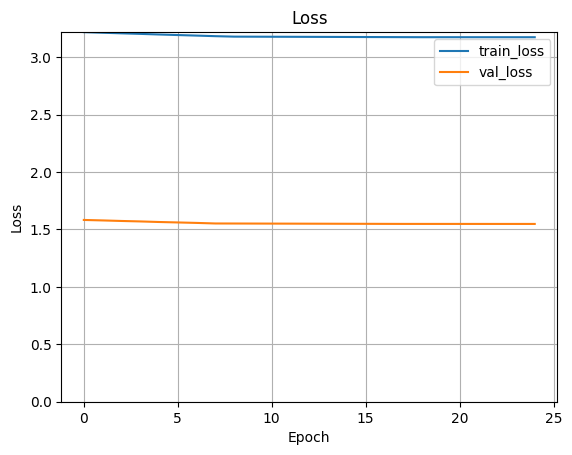

In [71]:
plot_loss(history)

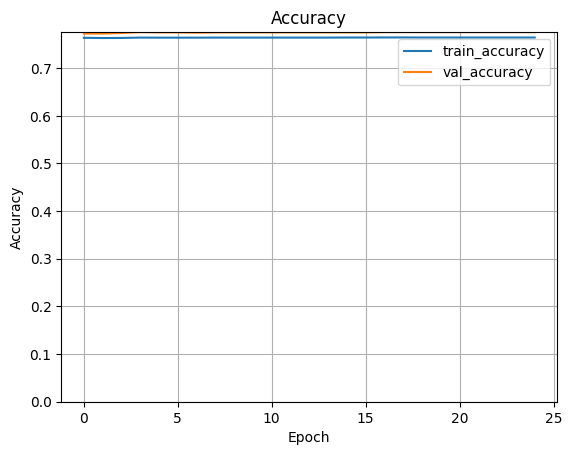

In [72]:
plot_accuracy(history)

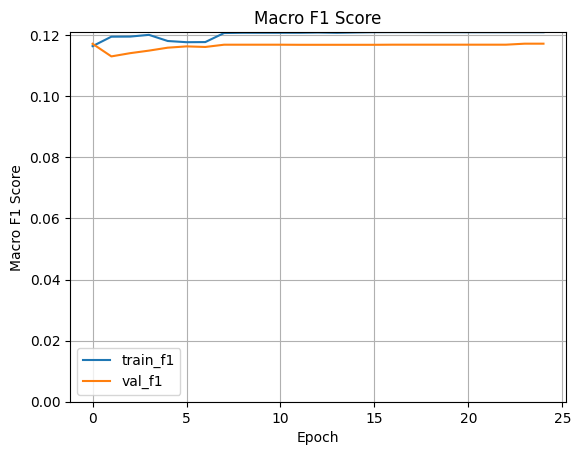

In [73]:
plot_f1_macro(history)

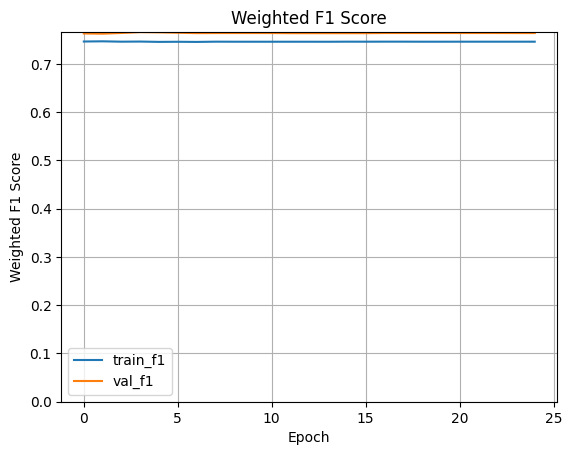

In [74]:
plot_f1_weighted(history)

**Validation Analysis of Best Checkpoint Model**

In [75]:
# load the model
filepath = "model.19"
best_model = load_model(filepath)

In [76]:
y_pred = best_model.predict([images_mini_v, street_mini_2_v, historical_val])
y_pred

53/53 [==============================] - 16s 302ms/step


array([[0.2563554 , 0.13927287, 0.07101722, ..., 0.12213712, 0.06464845,
        0.03047873],
       [0.16944867, 0.11341552, 0.21028472, ..., 0.08528711, 0.04063158,
        0.01965777],
       [0.25772658, 0.13244125, 0.08710597, ..., 0.12399143, 0.05940009,
        0.03038199],
       ...,
       [0.17573665, 0.10772504, 0.18696882, ..., 0.10316294, 0.04524762,
        0.0232253 ],
       [0.24620187, 0.11978864, 0.14334083, ..., 0.10715377, 0.04503217,
        0.02645627],
       [0.24842192, 0.12039877, 0.11425491, ..., 0.12189357, 0.05192682,
        0.03004039]], dtype=float32)

In [77]:
pred_values = []
for i in y_pred: 
    input_list = i
    max_value = max(input_list)
    index = [index for index, item in enumerate(input_list) if item == max_value]
    pred_values.append(index[0])
pred_values[0:5]

[0, 2, 0, 0, 0]

In [78]:
y_true = list(y_val)
y_true[0:5]

[0, 0, 0, 0, 0]

<Axes: title={'center': 'Confusion Matrix'}>

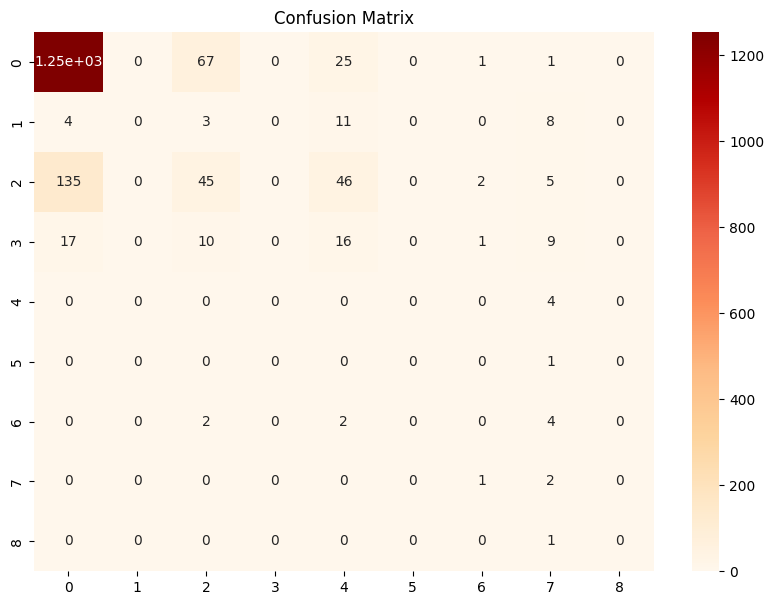

In [79]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true, pred_values)
ind = max(max(np.unique(y_true)), max(np.unique(pred_values))) + 1
df_cm = pd.DataFrame(cm, index = [i for i in range(ind)],
                  columns = [i for i in range(ind)])
df_cm
plt.figure(figsize = (10,7))
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
sn.heatmap(df_cm, annot=True, fmt='.3g',cmap="OrRd")

**Training best model with validation set**

In [94]:
# load the model
filepath = "model.19"
best_model = load_model(filepath)

In [108]:
print(images_mini.shape)
print(images_mini_v.shape)
images_mini_train_val = np.concatenate((images_mini, images_mini_v), axis = 0)
images_mini_train_val.shape

(6700, 148, 188, 4)
(1676, 148, 188, 4)


(8376, 148, 188, 4)

In [107]:
print(street_mini_2.shape)
print(street_mini_2_v.shape)
street_mini_train_val = np.concatenate((street_mini_2, street_mini_2_v), axis = 0)
street_mini_train_val.shape

(6700, 50, 50, 38)
(1676, 50, 50, 38)


(8376, 50, 50, 38)

In [109]:
print(historical_train.shape)
print(historical_val.shape)
historical_train_val = np.concatenate((historical_train, historical_val), axis = 0)
historical_train_val.shape

(6700, 1)
(1676, 1)


(8376, 1)

In [110]:
print(y_train.shape)
print(y_val.shape)
y_train_val = np.concatenate((y_train, y_val), axis = 0)
y_train_val.shape

(6700,)
(1676,)


(8376,)

In [114]:
#define the checkpoint
filepath = "model.19.val.included"
checkpoint = ModelCheckpoint(filepath, monitor='val_f1_weighted', verbose=1, save_best_only=True, mode='max')
callbacks_check = checkpoint

def scheduler(epoch, lr):
    if epoch < 6:
        return 0.0001
    elif epoch < 11:
        return 0.00001
    else:
        return 0.000001

callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

y_tv = tf.keras.utils.to_categorical(y_train_val, num_classes=11)

y_v = tf.keras.utils.to_categorical(y_val, num_classes=11)

history = best_model.fit(
    [images_mini_train_val, street_mini_train_val, historical_train_val],
    y_tv,
    epochs=15,
    # Suppress logging.
     verbose=1,
    validation_data=([images_mini_v, street_mini_2_v, historical_val], y_v),
    # Calculate validation results on 20% of the training data.
    #validation_split = 0.2,
    class_weight = class_weights,
    callbacks=[callback, callbacks_check],
    )

Epoch 1/15
262/262 [==============================] - ETA: 0s - loss: 2.9508 - accuracy: 0.7724 - precision_7: 0.6250 - f1_macro: 0.1174 - f1_weighted: 0.7500 
Epoch 1: val_f1_weighted improved from -inf to 0.76437, saving model to model.19.val.included


INFO:tensorflow:Assets written to: model.19.val.included/assets


INFO:tensorflow:Assets written to: model.19.val.included/assets


262/262 [==============================] - 4055s 15s/step - loss: 2.9508 - accuracy: 0.7724 - precision_7: 0.6250 - f1_macro: 0.1174 - f1_weighted: 0.7500 - val_loss: 1.5063 - val_accuracy: 0.7810 - val_precision_7: 0.5000 - val_f1_macro: 0.1164 - val_f1_weighted: 0.7644 - lr: 1.0000e-04
Epoch 2/15
262/262 [==============================] - ETA: 0s - loss: 2.9017 - accuracy: 0.7715 - precision_7: 0.5600 - f1_macro: 0.1179 - f1_weighted: 0.7498 
Epoch 2: val_f1_weighted did not improve from 0.76437
262/262 [==============================] - 4047s 15s/step - loss: 2.9017 - accuracy: 0.7715 - precision_7: 0.5600 - f1_macro: 0.1179 - f1_weighted: 0.7498 - val_loss: 1.4723 - val_accuracy: 0.7798 - val_precision_7: 0.8000 - val_f1_macro: 0.1206 - val_f1_weighted: 0.7632 - lr: 1.0000e-04
Epoch 3/15
262/262 [==============================] - ETA: 0s - loss: 2.8589 - accuracy: 0.7714 - precision_7: 0.5116 - f1_macro: 0.1254 - f1_weighted: 0.7497 
Epoch 3: val_f1_weighted did not improve from 0.

INFO:tensorflow:Assets written to: model.19.val.included/assets


INFO:tensorflow:Assets written to: model.19.val.included/assets


262/262 [==============================] - 4047s 15s/step - loss: 2.6910 - accuracy: 0.7633 - precision_7: 0.4217 - f1_macro: 0.1457 - f1_weighted: 0.7507 - val_loss: 1.3986 - val_accuracy: 0.7715 - val_precision_7: 0.4667 - val_f1_macro: 0.1574 - val_f1_weighted: 0.7646 - lr: 1.0000e-05
Epoch 10/15
262/262 [==============================] - ETA: 0s - loss: 2.6876 - accuracy: 0.7635 - precision_7: 0.4146 - f1_macro: 0.1438 - f1_weighted: 0.7507 
Epoch 10: val_f1_weighted improved from 0.76459 to 0.76552, saving model to model.19.val.included


INFO:tensorflow:Assets written to: model.19.val.included/assets


INFO:tensorflow:Assets written to: model.19.val.included/assets


262/262 [==============================] - 4035s 15s/step - loss: 2.6876 - accuracy: 0.7635 - precision_7: 0.4146 - f1_macro: 0.1438 - f1_weighted: 0.7507 - val_loss: 1.3968 - val_accuracy: 0.7721 - val_precision_7: 0.4667 - val_f1_macro: 0.1574 - val_f1_weighted: 0.7655 - lr: 1.0000e-05
Epoch 11/15
262/262 [==============================] - ETA: 0s - loss: 2.6840 - accuracy: 0.7611 - precision_7: 0.4253 - f1_macro: 0.1459 - f1_weighted: 0.7496 
Epoch 11: val_f1_weighted improved from 0.76552 to 0.76597, saving model to model.19.val.included


INFO:tensorflow:Assets written to: model.19.val.included/assets


INFO:tensorflow:Assets written to: model.19.val.included/assets


262/262 [==============================] - 4040s 15s/step - loss: 2.6840 - accuracy: 0.7611 - precision_7: 0.4253 - f1_macro: 0.1459 - f1_weighted: 0.7496 - val_loss: 1.3954 - val_accuracy: 0.7721 - val_precision_7: 0.4667 - val_f1_macro: 0.1572 - val_f1_weighted: 0.7660 - lr: 1.0000e-05
Epoch 12/15
262/262 [==============================] - ETA: 0s - loss: 2.6795 - accuracy: 0.7619 - precision_7: 0.4186 - f1_macro: 0.1469 - f1_weighted: 0.7503 
Epoch 12: val_f1_weighted did not improve from 0.76597
262/262 [==============================] - 4038s 15s/step - loss: 2.6795 - accuracy: 0.7619 - precision_7: 0.4186 - f1_macro: 0.1469 - f1_weighted: 0.7503 - val_loss: 1.3952 - val_accuracy: 0.7721 - val_precision_7: 0.4667 - val_f1_macro: 0.1572 - val_f1_weighted: 0.7660 - lr: 1.0000e-06
Epoch 13/15
262/262 [==============================] - ETA: 0s - loss: 2.6792 - accuracy: 0.7622 - precision_7: 0.4186 - f1_macro: 0.1469 - f1_weighted: 0.7505 
Epoch 13: val_f1_weighted did not improve fro

**Test Best Model**

In [115]:
street_mini_2_t = [] 
for k in range(len(street_t)):
    for i in range(50): 
        for j in range(50):
            street_mini_2_t.append(street_t[k])
street_mini_2_t = np.reshape(street_mini_2_t, (len(street_t),50,50,38))
np.shape(street_mini_2_t)

(2095, 50, 50, 38)

In [116]:
# load the model
filepath = "model.19.val.included"
best_model = load_model(filepath)

In [117]:
y_pred = best_model.predict([images_mini_t, street_mini_2_t, historical_test])
y_pred[0]

66/66 [==============================] - 20s 305ms/step


array([0.2780929 , 0.1152548 , 0.08699143, 0.09093944, 0.08856206,
       0.01867929, 0.03599451, 0.03189603, 0.14927873, 0.05686704,
       0.04744391], dtype=float32)

In [118]:
pred_values = []
for i in y_pred: 
    input_list = i
    max_value = max(input_list)
    index = [index for index, item in enumerate(input_list) if item == max_value]
    pred_values.append(index[0])
pred_values[0:5]

[0, 4, 0, 0, 0]

In [119]:
y_true = list(y_test)
y_true[0:5]

[0, 4, 0, 0, 0]

<Axes: title={'center': 'Confusion Matrix'}>

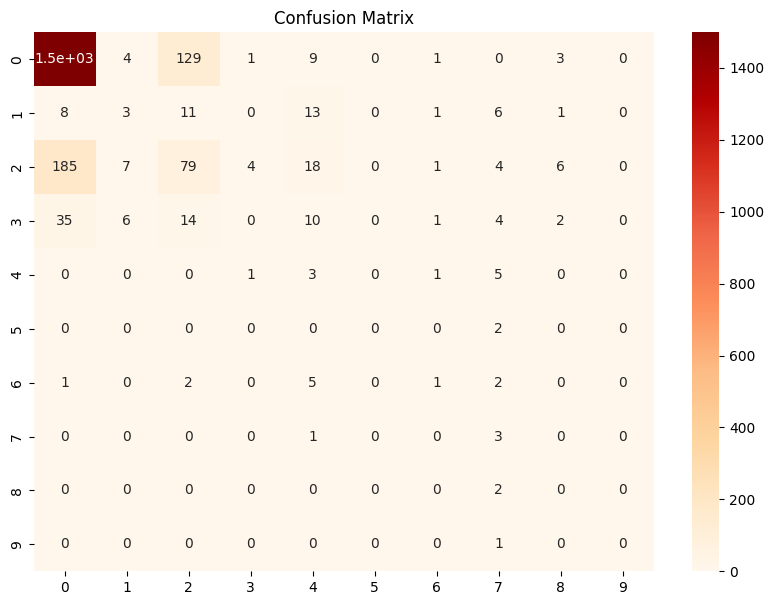

In [120]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true, pred_values)
ind = max(max(np.unique(y_true)), max(np.unique(pred_values))) + 1
df_cm = pd.DataFrame(cm, index = [i for i in range(ind)],
                  columns = [i for i in range(ind)])
df_cm
plt.figure(figsize = (10,7))
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
sn.heatmap(df_cm, annot=True, fmt='.3g',cmap="OrRd")

In [121]:
df_cm

,0,1,2,3,4,5,6,7,8,9
0,1499,4,129,1,9,0,1,0,3,0
1,8,3,11,0,13,0,1,6,1,0
2,185,7,79,4,18,0,1,4,6,0
3,35,6,14,0,10,0,1,4,2,0
4,0,0,0,1,3,0,1,5,0,0
5,0,0,0,0,0,0,0,2,0,0
6,1,0,2,0,5,0,1,2,0,0
7,0,0,0,0,1,0,0,3,0,0
8,0,0,0,0,0,0,0,2,0,0
9,0,0,0,0,0,0,0,1,0,0


In [122]:
f1_score(y_true, pred_values, average = 'macro')

0.1663354866818392

In [123]:
f1_score(y_true, pred_values, average = 'weighted')

0.7439944743328033

In [124]:
f1_score(y_true, pred_values, average = None)

array([0.88855957, 0.0952381 , 0.29313544, 0.        , 0.08695652,
       0.        , 0.11764706, 0.18181818, 0.        , 0.        ])